# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

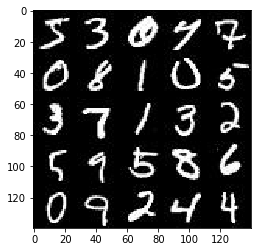

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

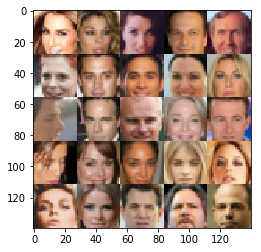

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


D:\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    
    return real_input, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        
        # input layer is 28x28x3        
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        # first does not use batch_normalization
        relu1 = tf.maximum(alpha*x1,x1)
        # 14x14x64
#        print(relu1.get_shape())
        
        # 
        x2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha*batch_norm2,batch_norm2)
        # 7x7x128
#        print(relu2.get_shape())
        
        x3 = tf.layers.conv2d(relu2,256,5,strides=2,padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
#        x3 = tf.layers.conv2d(relu2,256,5,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(alpha*batch_norm3,batch_norm3)
        # 4x4x256
#        print(relu3.get_shape())
        
        # 1st
        flat = tf.reshape(relu3, (-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = True
    if is_train == True:
        reuse = False
    
    with tf.variable_scope('generator', reuse=reuse): #
        alpha = 0.2
        # Fully connected layer
        # 1st
        x0 = tf.layers.dense(z,7*7*512)

        # 1st
        x0 = tf.reshape(x0, (-1,7,7,512))
        x0 = tf.layers.batch_normalization(x0,training=is_train)
        x0 = tf.maximum(alpha*x0,x0)
        # now 7x7x512
        #print(x0.get_shape())

        # 1st
        x1 = tf.layers.conv2d_transpose(x0,256,5,strides=2,padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha*x1,x1)
#        print(x1.get_shape())
        # now 14x14x256

        x2 = tf.layers.conv2d_transpose(x1,128,5,strides=2,padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
#        print(x2.get_shape())
        # now 28x28x128
        
        # 1st shape, added kernel_init
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim,5, strides=1,padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim
#        print(logits.get_shape())
        # with 28x28x5
        
        out = tf.tanh(logits)
        
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
#    alpha = 0.2
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
# z_size = z_dim
# 72?
#def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
#    saver = tf.train.Saver()
    print_every=10
    show_every= 100 # 100
    # 
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim)) 
    
    samples, losses = [], []
    steps = 0
    
    # GAN
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    # from:
    # https://discussions.udacity.com/t/train-function-need-help/249002/3
    # substitute net. with
    # Inputs
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    # def model_inputs(image_width, image_height, image_channels, z_dim):

# Loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)

# Optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1) #  (lr is parameter space)?
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # x = batch_images
                # e = epoch_i
                # epochs = epoch_count
                # generator(z, out_channel_dim, is_train=True):
                steps += 1
                
                # since I use a tanh in the generator
                batch_images = batch_images * 2
#                sample_z = np.random.uniform(-1, 1, size=(72, z_dim)) 
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr : learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr : learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False), 
                        # generator(z, out_channel_dim, is_train=True):
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
#                    _ = show_generator_output(-1, samples, 6, 12, figsize=figsize) # view_samples
                    show_generator_output(sess=sess, n_images = 10, input_z = input_z, out_channel_dim = image_channels, image_mode = data_image_mode)
                    #plt.show()

#        saver.save(sess, './checkpoints/generator.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
batch_size = 64 #32?
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 0.2284... Generator Loss: 2.0211
Epoch 1/2... Discriminator Loss: 0.3899... Generator Loss: 4.3487
Epoch 1/2... Discriminator Loss: 0.3035... Generator Loss: 2.1358
Epoch 1/2... Discriminator Loss: 1.0755... Generator Loss: 1.0747


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1919... Generator Loss: 4.3156
Epoch 1/1... Discriminator Loss: 3.4835... Generator Loss: 0.2344
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 0.5773... Generator Loss: 2.0327
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 5.1077
Epoch 1/1... Discriminator Loss: 1.7559... Generator Loss: 0.3114
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.6561... Generator Loss: 3.9323
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.6416


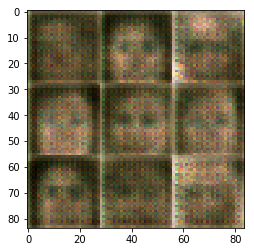

Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.6199
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 2.7793... Generator Loss: 0.1542
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 1.8661
Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 2.9891
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.4229
Epoch 1/1... Discriminator Loss: 0.5526... Generator Loss: 2.0708
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.6307


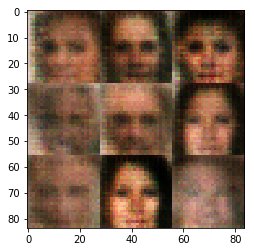

Epoch 1/1... Discriminator Loss: 1.9164... Generator Loss: 0.2610
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 1.4794
Epoch 1/1... Discriminator Loss: 2.0584... Generator Loss: 2.8290
Epoch 1/1... Discriminator Loss: 1.6210... Generator Loss: 0.3114
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 1.5254
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6418


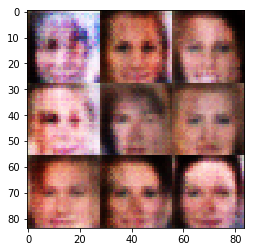

Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 3.0295
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 4.5470
Epoch 1/1... Discriminator Loss: 0.6934... Generator Loss: 1.3281
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.4192
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.8080
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.3184
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.4304


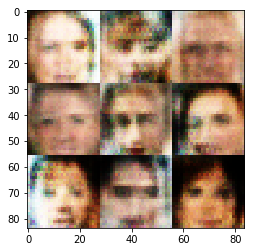

Epoch 1/1... Discriminator Loss: 2.0411... Generator Loss: 6.8370
Epoch 1/1... Discriminator Loss: 0.4376... Generator Loss: 1.4432
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.3966
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 1.2898
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 0.1793... Generator Loss: 3.6375
Epoch 1/1... Discriminator Loss: 0.4423... Generator Loss: 2.5109
Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 2.0414
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.6371... Generator Loss: 0.2826


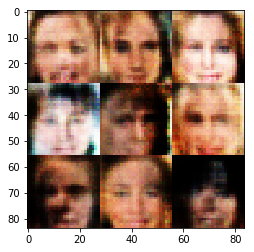

Epoch 1/1... Discriminator Loss: 0.4951... Generator Loss: 2.6184
Epoch 1/1... Discriminator Loss: 0.0975... Generator Loss: 7.2176
Epoch 1/1... Discriminator Loss: 0.1084... Generator Loss: 6.3260
Epoch 1/1... Discriminator Loss: 0.3748... Generator Loss: 1.4799
Epoch 1/1... Discriminator Loss: 0.0731... Generator Loss: 4.0575
Epoch 1/1... Discriminator Loss: 1.5109... Generator Loss: 0.5491
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 0.3063
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.4609
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 1.1108


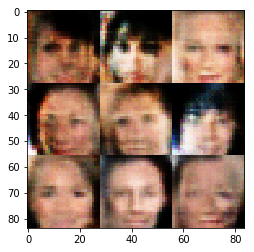

Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 4.5330
Epoch 1/1... Discriminator Loss: 0.1614... Generator Loss: 3.0264
Epoch 1/1... Discriminator Loss: 0.2444... Generator Loss: 2.0831
Epoch 1/1... Discriminator Loss: 0.0872... Generator Loss: 4.3954
Epoch 1/1... Discriminator Loss: 0.2086... Generator Loss: 2.0567
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.4678
Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 1.4141
Epoch 1/1... Discriminator Loss: 0.0447... Generator Loss: 4.7560
Epoch 1/1... Discriminator Loss: 1.7008... Generator Loss: 0.2748


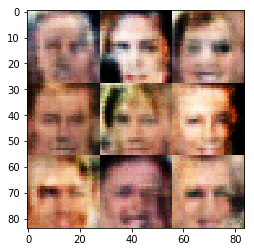

Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.3903
Epoch 1/1... Discriminator Loss: 0.1150... Generator Loss: 3.9351
Epoch 1/1... Discriminator Loss: 0.5135... Generator Loss: 1.2043
Epoch 1/1... Discriminator Loss: 0.6355... Generator Loss: 1.0642
Epoch 1/1... Discriminator Loss: 2.8712... Generator Loss: 3.1493
Epoch 1/1... Discriminator Loss: 0.4543... Generator Loss: 1.5770
Epoch 1/1... Discriminator Loss: 0.2202... Generator Loss: 5.5972
Epoch 1/1... Discriminator Loss: 0.0670... Generator Loss: 3.7445
Epoch 1/1... Discriminator Loss: 0.0804... Generator Loss: 3.4487
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 1.7969


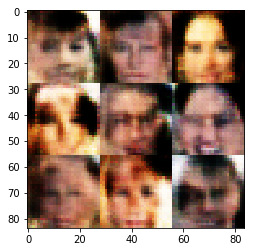

Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 1.6459
Epoch 1/1... Discriminator Loss: 1.6837... Generator Loss: 2.2508
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.6926
Epoch 1/1... Discriminator Loss: 2.1534... Generator Loss: 0.1674
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 1.3277
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.4590
Epoch 1/1... Discriminator Loss: 1.7712... Generator Loss: 2.4554
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.5751


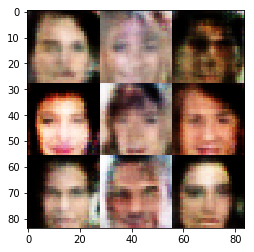

Epoch 1/1... Discriminator Loss: 0.2598... Generator Loss: 4.0442
Epoch 1/1... Discriminator Loss: 0.2835... Generator Loss: 2.0772
Epoch 1/1... Discriminator Loss: 0.1225... Generator Loss: 3.9722
Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 0.2182... Generator Loss: 2.1290
Epoch 1/1... Discriminator Loss: 2.9537... Generator Loss: 0.0717
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.5345
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 2.6809
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.6346


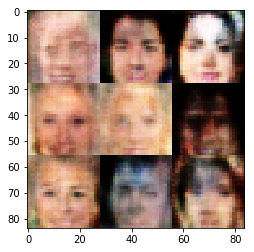

Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 0.6683... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 1.3887
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.4069
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.3580
Epoch 1/1... Discriminator Loss: 0.1199... Generator Loss: 2.7013
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 4.1506
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 5.9438
Epoch 1/1... Discriminator Loss: 0.2648... Generator Loss: 2.6560
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 5.1795


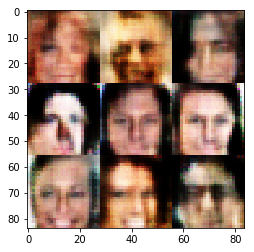

Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.5518
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 1.3154
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.3367
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 2.6292
Epoch 1/1... Discriminator Loss: 0.3394... Generator Loss: 3.0576
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 6.7908
Epoch 1/1... Discriminator Loss: 0.5545... Generator Loss: 1.0756
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 0.2810... Generator Loss: 1.7430


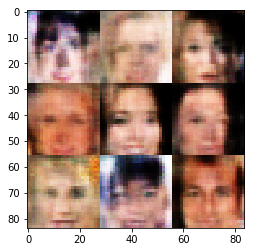

Epoch 1/1... Discriminator Loss: 0.1586... Generator Loss: 2.3553
Epoch 1/1... Discriminator Loss: 0.3892... Generator Loss: 1.9097
Epoch 1/1... Discriminator Loss: 0.1047... Generator Loss: 3.0816
Epoch 1/1... Discriminator Loss: 0.3040... Generator Loss: 1.7387
Epoch 1/1... Discriminator Loss: 0.2108... Generator Loss: 2.1950
Epoch 1/1... Discriminator Loss: 0.3188... Generator Loss: 1.5358
Epoch 1/1... Discriminator Loss: 0.0503... Generator Loss: 4.4947
Epoch 1/1... Discriminator Loss: 0.0549... Generator Loss: 3.8472
Epoch 1/1... Discriminator Loss: 0.1178... Generator Loss: 3.1768
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.5440


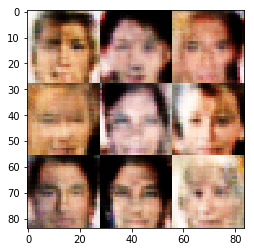

Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.4086
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.6720
Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.5069
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.2945
Epoch 1/1... Discriminator Loss: 1.7619... Generator Loss: 2.7504
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.6851
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.7350


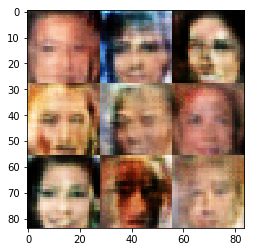

Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.3405
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 3.0074
Epoch 1/1... Discriminator Loss: 0.4871... Generator Loss: 1.2399
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 2.2525
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 2.6089
Epoch 1/1... Discriminator Loss: 0.5894... Generator Loss: 1.2656
Epoch 1/1... Discriminator Loss: 0.1149... Generator Loss: 3.4473
Epoch 1/1... Discriminator Loss: 0.4420... Generator Loss: 1.3796
Epoch 1/1... Discriminator Loss: 0.0860... Generator Loss: 6.0043


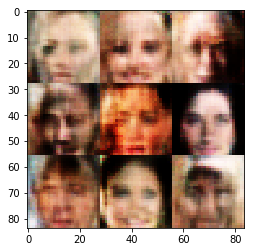

Epoch 1/1... Discriminator Loss: 0.0586... Generator Loss: 5.5459
Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.6373... Generator Loss: 8.0906
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 1.1117
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 0.1791... Generator Loss: 3.1034


In [15]:
##### 
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5 # 0.001

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.